In [1]:
import os
os.chdir(os.path.dirname(os.path.abspath('..')))

device_ids = [3]

# CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, device_ids))

In [2]:
import logging
import sys
from pathlib import Path
from datetime import date, datetime, timedelta
from typing import Tuple, List
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display
import cmcrameri.cm as cmc


from AltimeterAutoencoder.src import _types
from AltimeterAutoencoder.src.regressor import fit_regressor, MetaRegression
from Models.AttentionConvLSTM import SaveLoadModels
from Models.AttentionConvLSTM.training_loop import train_validation_loop
from Models.AttentionConvLSTM.Seq2SeqAttention import Seq2SeqAttention, InputModel, OutputModel
from Models.Shared import Loss, DatasetParameters
from Models.Shared.Dataloader import SLADataset
from Models.AttentionConvLSTM import Attention, Encoder, Decoder
from Models.AttentionConvLSTM.Loss import create_masked_loss_function_diff

%load_ext autoreload
%autoreload 2

def print_to_file_on_epoch(loss: Loss, _: _types.float_like, __: _types.float_like, train_mse_losses, train_grad_losses, val_mse_losses, val_grad_losses, n_epochs: int):
    logger = logging.getLogger(__name__)
    logger.info(f"Epoch: {loss.epoch:04d}/{n_epochs} Training Loss: {loss.training_loss:.7f} Validation Loss: {loss.validation_loss:.7f}")
    
    logger = logging.getLogger("MSE")
    logger.info(f"Epoch: {loss.epoch:04d}/{n_epochs} | Train: {','.join(train_mse_losses.astype(str))} | Validation: {','.join(val_mse_losses.astype(str))}")
    
    logger = logging.getLogger("GRAD_MSE")
    logger.info(f"Epoch: {loss.epoch:04d}/{n_epochs} | Train: {','.join(train_grad_losses.astype(str))} | Validation: {','.join(val_grad_losses.astype(str))}")

def setup_model(
    in_channels: int,
    encoder_in_channels: int,
    encoder_out_channels: int,
    kernel_size: Tuple[int, int],
    padding: Tuple[int, int],
    frame_size: Tuple[int, int],
    hidden_output_network_channels: List[int]
) -> Seq2SeqAttention:
    # Construct models
    input_model = InputModel(in_channels, encoder_in_channels)

    encoder = Encoder(
        in_channels = encoder_in_channels,
        out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        activation = nn.Tanh(),
        frame_size = frame_size,
    )

    attention = Attention(encoder_out_channels, encoder_out_channels)

    decoder = Decoder(
        in_channels = encoder_in_channels,
        hidden_channels = encoder_out_channels,
        out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        activation = nn.Tanh(),
        frame_size = frame_size,
        attention = attention
    )

    output_network = OutputModel(
        in_channels = decoder.resulting_channels,
        hidden_channels = hidden_output_network_channels,
        output_channels = in_channels
    )
    return Seq2SeqAttention(input_model, encoder, decoder, output_network)

def load_model(
    model_path: Path,
    device: torch.device,
    regressor_path: Path
) -> Tuple[Seq2SeqAttention, torch.optim.Optimizer, Loss, DatasetParameters, MetaRegression, int, str]:
    model, optimizer, last_loss, dataset_parameters = SaveLoadModels.load_checkpoint(
        model_path,
        Seq2SeqAttention,
        device
    )
    with open(regressor_path, 'rb') as file:
        regressor = MetaRegression.load(file)
    start_epoch = last_loss.epoch
    return model, optimizer, last_loss, dataset_parameters, regressor, start_epoch

def setup_data(
    datapath: Path,
    save_path: Path,
    dataset_parameters: DatasetParameters,
    regressor: MetaRegression | None = None
) -> Tuple[DataLoader[SLADataset], DataLoader[SLADataset]]:
    with xr.open_dataset(DATAPATH, engine="netcdf4") as file:
        file = file.sortby('time')
        sla = file['sla21'][:, :-1][:, 20:40, 185:225].data
        times: _types.time_like = file['time'].data

    # Set train, validation and test intervals
    train_start_np = np.array(dataset_parameters.train_start).astype("datetime64[ns]")
    train_end = np.array(dataset_parameters.train_end).astype("datetime64[ns]")
    validation_end = np.array(dataset_parameters.validation_end).astype("datetime64[ns]")

    # Save times
    bool_train = (times > train_start_np) & (times <= train_end)
    bool_validation = (times > train_end) & (times <= validation_end)

    if regressor is None:
        regressor = fit_regressor(times[bool_train], sla[bool_train], save_path)

    sla -= regressor.predict(times).reshape(*sla.shape)
    train_time: _types.int_like = times[bool_train].astype("datetime64[D]").astype(int)
    validation_time: _types.int_like = times[bool_validation].astype("datetime64[D]").astype(int)

    # Save sla features
    train_features = sla[bool_train]
    validation_features = sla[bool_validation]

    # Kwargs to dataloaders
    kwargs_dataloader = {
        'shuffle': False,
        'batch_size': dataset_parameters.batch_size
    }

    # Dataloders
    train_loader = DataLoader(SLADataset(train_features, train_time, dataset_parameters), **kwargs_dataloader)
    validation_loader = DataLoader(SLADataset(validation_features, validation_time, dataset_parameters), **kwargs_dataloader)
    return train_loader, validation_loader

In [3]:
class PlotOnEpoch:
    def __init__(
        self,
        print_to_file: bool = True,
        day_number_first: int = 0,
        day_number_second: int = 29,
        plot_every: int = 5
    ):
        self.plot_every = plot_every
        self.extent = [5.5, 44.5, -44.5, -25.5]
        self.print_to_file = print_to_file
        self.day_number_first = day_number_first
        self.day_number_second = day_number_second
        self.losses = []
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.times = []
        self.train_mse_losses = None
        self.validation_mse_losses = None
        self.fig, self.axes = plt.subplots(5, 2, figsize=(14, 26))
        self._no_title = True
        self.total_epochs = 0
        self.example_images_truth = []
        self.example_images_pred = []
    
        self.ax_epoch = self.axes[0, 0]
        self.ax_epoch_all = self.axes[0, 1]

        self.ax_epoch_train_color = self.axes[1, 0]
        self.ax_epoch_val_color = self.axes[1, 1]

        self.ax_learningrate = self.axes[2, 0]
        self.ax_time = self.axes[2, 1]

        self.ax_example_img_true_first = self.axes[3, 0]
        self.ax_example_img_pred_first = self.axes[3, 1]

        self.ax_example_img_true_second = self.axes[4, 0]
        self.ax_example_img_pred_second = self.axes[4, 1]
    
    def __call__(self, loss, example_img_true, example_img_pred, train_mse_loss, train_grad_loss, val_mse_loss, val_grad_loss, total_epochs):
        if self.print_to_file:
            print_to_file_on_epoch(loss, example_img_true, example_img_pred, train_mse_loss, train_grad_loss, val_mse_loss, val_grad_loss, total_epochs)
        
        if self.train_mse_losses is None:
            self.train_mse_losses = train_mse_loss[np.newaxis,:]
        else:
            self.train_mse_losses = np.vstack([self.train_mse_losses, train_mse_loss])
        
        if self.validation_mse_losses is None:
            self.validation_mse_losses = val_mse_loss[np.newaxis,:]
        else:
            self.validation_mse_losses = np.vstack([self.validation_mse_losses, val_mse_loss])

        self.total_epochs = total_epochs
        self.example_images_truth.append(
            (example_img_true[self.day_number_first], example_img_true[self.day_number_second])
        )
        self.example_images_pred.append(
            (example_img_pred[self.day_number_first], example_img_pred[self.day_number_second])
        )
        self.losses.append(loss)
        self.train_loss.append(loss.training_loss)
        self.val_loss.append(loss.validation_loss)
        self.epochs.append(loss.epoch)

        if len(self.losses) > 1:
            total_seconds = (loss.time - self.losses[-2].time).total_seconds()/60
            self.times.append(total_seconds)
        
        if loss.epoch % self.plot_every == 0:
            self.update_figure()
    
    def update_figure(self, update_title: bool = False):
        
        if len(self.losses) > 1:
            total_seconds = self.times[-1]
            estimated_next_epoch = datetime.now() + timedelta(seconds=total_seconds*60)
            self.fig.suptitle(f"Estimated time left: {total_seconds/60 * (self.total_epochs - self.losses[-1].epoch):.2f} h\nEstimated next epoch: {estimated_next_epoch.strftime('%H:%M:%S')}")
            self.ax_time.plot(self.epochs[1:], self.times, color='red')
        
        self.ax_epoch.plot(self.epochs, self.train_loss, color='red', label="Training")
        self.ax_epoch.plot(self.epochs, self.val_loss, color='blue', label="Validation")
        self.ax_epoch.set_ylim([min(self.train_loss[-1], self.val_loss[-1])*0.9, max(self.train_loss[-1], self.val_loss[-1])*1.1])
        self.ax_epoch_all.plot(self.epochs, self.train_loss, color='red', label="Training")
        self.ax_epoch_all.plot(self.epochs, self.val_loss, color='blue', label="Validation")        

        vmin = 0
        vmax = 6
        train_cbar = self.ax_epoch_train_color.imshow(self.train_mse_losses.T, vmin=vmin, vmax=vmax, origin='lower', cmap='jet', interpolation="nearest", aspect='auto')
        val_cbar = self.ax_epoch_val_color.imshow(self.validation_mse_losses.T, vmin=vmin, vmax=vmax, origin='lower', cmap='jet', interpolation="nearest", aspect='auto')

        im_pred_first = self.ax_example_img_pred_first.imshow(self.example_images_pred[-1][0] * 100, extent=self.extent, vmin=-50, vmax=50, origin='lower', cmap=cmc.vik)
        im_true_first = self.ax_example_img_true_first.imshow(self.example_images_truth[-1][0] * 100, extent=self.extent, vmin=-50, vmax=50, origin='lower', cmap=cmc.vik)

        im_pred_second = self.ax_example_img_pred_second.imshow(self.example_images_pred[-1][1] * 100, extent=self.extent, vmin=-50, vmax=50, origin='lower', cmap=cmc.vik)
        im_true_second = self.ax_example_img_true_second.imshow(self.example_images_truth[-1][1] * 100, extent=self.extent, vmin=-50, vmax=50, origin='lower', cmap=cmc.vik)
        

        if self._no_title or update_title:
            self._no_title = False
            self.ax_epoch_train_color.set_title("Training loss for each day")
            self.ax_epoch_train_color.set_xlabel("Epoch")
            self.ax_epoch_train_color.set_ylabel("Day #")
            
            self.ax_epoch_val_color.set_title("Validation loss for each day")
            self.ax_epoch_val_color.set_xlabel("Epoch")
            self.ax_epoch_val_color.set_ylabel("Day #")
            
            self.ax_epoch.set_title(f"Loss")
            self.ax_epoch.legend(loc='upper right')
            self.ax_epoch.set_xlabel("Epoch")
            self.ax_epoch.set_ylabel("Loss")
            self.ax_epoch.grid()

            self.ax_epoch_all.set_title(f"Loss")
            self.ax_epoch_all.legend(loc='upper right')
            self.ax_epoch_all.set_xlabel("Epoch")
            self.ax_epoch_all.set_ylabel("Loss")
            self.ax_epoch_all.grid()

            self.ax_time.set_xlabel("Epoch")
            self.ax_time.set_ylabel("Time [Minutes]")
            self.ax_time.grid()

            self.ax_learningrate.set_xlabel("Epoch")
            self.ax_learningrate.set_ylabel("Learning rate")
            self.ax_learningrate.grid()

            for ax in [
                self.ax_example_img_true_first,
                self.ax_example_img_pred_first,
                self.ax_example_img_true_first,
                self.ax_example_img_pred_first
            ]:
                ax.set_xlabel("Lon")
                ax.set_ylabel("Lat")
            
            self.ax_example_img_true_first.set_title(f"True image {self.day_number_first + 1} days")
            self.ax_example_img_pred_first.set_title(f"Prediction {self.day_number_first + 1} days")
            self.ax_example_img_true_second.set_title(f"True image {self.day_number_second + 1} days")
            self.ax_example_img_pred_second.set_title(f"Prediction {self.day_number_second + 1} days")

            plt.colorbar(im_true_first, ax = self.ax_example_img_true_first)
            plt.colorbar(im_pred_first, ax = self.ax_example_img_pred_first)
            plt.colorbar(im_true_second, ax = self.ax_example_img_true_second)
            plt.colorbar(im_pred_second, ax = self.ax_example_img_pred_second)
            plt.colorbar(train_cbar, ax=self.ax_epoch_train_color)
            plt.colorbar(val_cbar, ax=self.ax_epoch_val_color)
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [4]:
DATAPATH = Path(r"Data/Grids/without_polar_v5_mss21.nc")
SAVEFOLDER = Path("SavedModels", "ConvLSTMAttentionSouthAfricaWeightedLoss")
MODEL_NAME = "checkpoint_100.pkl"
SAVEFOLDER.mkdir(parents=True, exist_ok=True)
LOAD_MODEL = False

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


formatter = logging.Formatter('%(asctime)s:%(message)s')


logger = logging.getLogger("MSE")
file_handler = logging.FileHandler(SAVEFOLDER / 'mse_log.log')
file_handler.setFormatter(formatter)
file_handler.setLevel(logging.DEBUG)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

logger = logging.getLogger("GRAD_MSE")
file_handler = logging.FileHandler(SAVEFOLDER / 'grad_mse_log.log')
file_handler.setFormatter(formatter)
file_handler.setLevel(logging.DEBUG)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

logger = logging.getLogger(__name__)
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(formatter)
stream_handler.setLevel(logging.DEBUG)

file_handler = logging.FileHandler(SAVEFOLDER / 'log.log')
file_handler.setFormatter(formatter)
file_handler.setLevel(logging.DEBUG)

logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)


# Dataset parameters
default_batch_size = 45
default_sequence_length = 30
default_sequence_steps = 1
default_prediction_steps = 1
default_n_predictions = 30

# Model parameters
kernel_size = (3, 3)
padding = ((kernel_size[0] - 1)//2, (kernel_size[1] - 1)//2)
frame_size = (20, 40)
encoder_in_channels = 32
encoder_out_channels = 32
hidden_output_network_channels = [32, 32]

# Training loop
# Start: 53 - 1e-6
# Switch: 53 - 1e-3
learning_rate = 1e-4
weight_decay = 0
epochs = 2000
save_every = 25
n_sequences = 30
scheduler = None
teacher_forcing_ratio_list: List[float] = [0]*epochs
fill_nan = 0
train_start = date(2006, 1, 1)
train_end = date(2014, 1, 1)
validation_end = date(2019, 1, 1)

In [5]:
# Loss
criterion = create_masked_loss_function_diff(nn.MSELoss)

regressor = None
if LOAD_MODEL:
    model, optimizer, last_loss, dataset_parameters, regressor, start_epoch = load_model(
        SAVEFOLDER / MODEL_NAME,
        DEVICE,
        SAVEFOLDER / "Regression.pkl"
    )

In [6]:
if not LOAD_MODEL:
    dataset_parameters = DatasetParameters(
        batch_size = default_batch_size,
        sequence_length = default_sequence_length,
        sequence_steps = default_sequence_steps,
        prediction_steps = default_prediction_steps,
        fill_nan = fill_nan,
        train_start = train_start,
        train_end = train_end,
        validation_end = validation_end,
        n_predictions = default_n_predictions,
    )
    start_epoch = 0

    model = setup_model(
        in_channels = 1,
        encoder_in_channels = encoder_in_channels,
        encoder_out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        frame_size = frame_size,
        hidden_output_network_channels = []
    ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

try:
    with open(SAVEFOLDER / "Regression.pkl", 'rb') as file:
        regressor = MetaRegression.load(file)
except:
    regressor = None
    
train_loader, validation_loader = setup_data(
    DATAPATH,
    SAVEFOLDER / "Regression.pkl",
    dataset_parameters, # type: ignore
    regressor
)

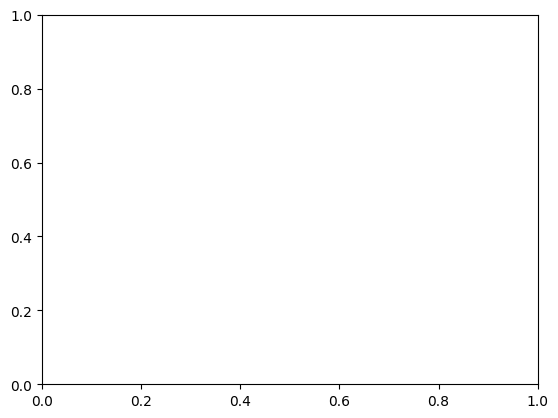

2023-07-13 17:06:33,787:Epoch: 0346/2000 Training Loss: 0.0294326 Validation Loss: 0.0655159
2023-07-13 17:07:45,764:Epoch: 0347/2000 Training Loss: 0.0294206 Validation Loss: 0.0654924


In [ ]:
# Train
update_images = PlotOnEpoch(
    print_to_file = True,
    day_number_first = 0,
    day_number_second = 29,
    plot_every = 5
)
for i in range(100):
    try:
        scheduler = None
        losses = train_validation_loop(
            model = model, # type: ignore
            train_loader = train_loader,
            val_loader = validation_loader,
            criterion = criterion,
            optimizer = optimizer, # type: ignore
            num_epochs = epochs,
            start_epoch = start_epoch, # type: ignore
            device = DEVICE,
            update_function = update_images,
            path = SAVEFOLDER,
            save_n_epochs = save_every,
            dataset_parameters = dataset_parameters, # type: ignore
            teacher_forcing_ratios = teacher_forcing_ratio_list,
            losses = None,
            scheduler = scheduler,
            n_sequences = n_sequences,
        )
        plt.close()
        break
    except ValueError as ex:
        plt.close()
        if LOAD_MODEL:
            raise ex
        update_images = PlotOnEpoch(
            print_to_file = True,
            day_number_first = 0,
            day_number_second = 29,
            plot_every = 5
        )
        model = setup_model(
            in_channels = 1,
            encoder_in_channels = encoder_in_channels,
            encoder_out_channels = encoder_out_channels,
            kernel_size = kernel_size,
            padding = padding,
            frame_size = frame_size,
            hidden_output_network_channels = []
        ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        print(f"{datetime.now()} | Failed {i} times", end='\r')

In [ ]:
with torch.no_grad():
    while True:
        features, target, mask, _, result_time = next(iter(validation_loader))
        # Save time
        batch_size = result_time.size(0)
        target_times = result_time.numpy()

        if torch.any(torch.all(torch.all(mask, dim=3), dim=2)):
            continue

        # Move to device
        features = features.to(DEVICE)
        target = target.to(DEVICE)
        mask = mask.to(DEVICE)

        # Predict
        output = model(features, None, n_sequences, 0)
        target = target.squeeze(1)
        output[mask] = np.nan
        target[mask] = np.nan
        output = output.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        break

In [ ]:
extent = [5.5, 44.5, -44.5, -25.5]
batch_id = 0
channel_id = 0
day_id = 29
plt.figure(figsize=(14,4))
plt.imshow(output[batch_id, day_id], origin='lower', cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
def get_pred_title_multi(dataset_parameters: DatasetParameters, n_predictions: int):
    return f"{n_predictions * dataset_parameters.prediction_steps} days predictions using {dataset_parameters.sequence_length} day(s) of data\nwith {dataset_parameters.sequence_steps - 1} day(s) inbetween"

def get_pred_title(dataset_parameters: DatasetParameters, n_predictions: int):
    return get_pred_title_multi(dataset_parameters, n_predictions).replace('\n', ' ')

idx = 0
day_prediction = 29

vmin = -0.75
vmax = 0.75
cmap = 'jet'

vmin_diff = -0.3
vmax_diff = 0.3

diffs = target - output
diff_data = diffs[idx, day_prediction]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

fig, axes = plt.subplots(3, 1, figsize=(16,10))
im_target = axes[0].imshow(target[idx, day_prediction], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(output[idx, day_prediction], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
axes[1].set_title(get_pred_title(dataset_parameters, day_prediction + 1))
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.animation
import matplotlib

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
plt.ioff()
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
vmin = -0.75
vmax = 0.75
cmap = 'jet'#cmc.vik

idx = 0
vmin_diff = -0.3
vmax_diff = 0.3

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

diff_data = diffs[idx, 0]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

im_target = axes[0].imshow(target[idx, 0], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(output[idx, 0], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
axes[1].set_title(get_pred_title(dataset_parameters, 1))
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")
caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")    

def animate(t):
    plt.cla()
    diff_data = diffs[idx, t]
    diff_vector = diff_data[~np.isnan(diff_data)].flatten()
    rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))
    
    im_target = axes[0].imshow(target[idx, t], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
    im_pred = axes[1].imshow(output[idx, t], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
    im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)
    
    axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
    axes[1].set_title(get_pred_title(dataset_parameters, t + 1))
    axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

anim  = matplotlib.animation.FuncAnimation(fig, animate, frames=29)



anim.save(SAVEFOLDER / f'{SAVEFOLDER.name}.gif')
plt.close()

In [ ]:
gif_file = (SAVEFOLDER / f'{SAVEFOLDER.name}.gif').as_posix()
display.Image(open(gif_file,'rb').read())